In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir('/content/drive/Shareddrives/Confidence Probes/taskdiscovery')
    !pip3 install transformer_lens fancy_einsum einops datasets encoders plotly circuitsvis

else:
    print("Not running in Google Colab, skipping installation of requirements.")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.5/594.5 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:

In [28]:
del sys.modules["training_utils"]
del sys.modules["lens"]
del sys.modules["hooks"]

In [29]:
from training_utils import load_model_data,plot_losses,LinePlot,fit_beta_model,show_token_preds, scatter
from lens import get_lens_loss,run_modal_lens_with_dir
import torch
from torch.distributions import Categorical
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
import pickle
import math
from functools import partial
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
model_name = "gpt2-small"
batch_size = 16
device, model, tokenizer, owt_iter = load_model_data(model_name, batch_size)
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads
head_dim = model.cfg.d_head
d_model = model.cfg.d_model
lr = 1e-3

folder = "./results/"
shared_bias = False

print(n_layers, n_heads, head_dim, d_model)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (61422 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (58948 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (59558 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (71857 > 1024). Running this sequence through the model will result in indexing errors


12 12 64 768


In [4]:
with open(f"{folder}/modal_lens_weights.pkl", "rb") as f:
    attn_bias = pickle.load(f)

for param in model.parameters():
    param.requires_grad = False

activations = []
all_kl_losses = []
all_ce_losses = []
outputs = []
for i in tqdm(range(1000)):
    batch = next(owt_iter)['tokens']

    with torch.no_grad():
        kl_losses, ce_losses, activation_storage, output = get_lens_loss(batch,
                                                      model,
                                                      n_layers,
                                                      attn_bias,
                                                      batch_size,
                                                      return_cross_entropy = True,
                                                      compare_tuned_lens=False)
        outputs.append(output.cpu())
        all_kl_losses.append(kl_losses.cpu())
        all_ce_losses.append(ce_losses.cpu())
        activations.append(torch.stack(activation_storage).cpu())

100%|██████████| 1000/1000 [00:59<00:00, 16.76it/s]


In [5]:
all_activations = torch.cat(activations, dim = 1).permute(1,0,2).cpu().numpy()
entropy = -1* (torch.cat(outputs) * torch.cat(outputs).log()).sum(-1).repeat(n_layers, 1 ).numpy().T
pure_losses = torch.cat(all_kl_losses, dim = 1).cpu().numpy().T
modal_lens_ce_losses = torch.cat(all_ce_losses, dim = 1).cpu().numpy().T

In [8]:
dirs,r2s,predictions,y_test = fit_beta_model(all_activations,
                      np.log(pure_losses),
                      fit_intercept = False,
                      )

pd.DataFrame({"layers": [f"layer_{i+1}" for i in range(n_layers)],
              "train_r2": [x[0] for x in r2s],
              "test_r2": [x[1] for x in r2s]})


,layers,train_r2,test_r2
0,layer_1,0.347,0.244
1,layer_2,0.455,0.352
2,layer_3,0.448,0.352
3,layer_4,0.457,0.360
4,layer_5,0.480,0.404
5,layer_6,0.506,0.439
6,layer_7,0.516,0.464
7,layer_8,0.549,0.481
8,layer_9,0.577,0.514
9,layer_10,0.627,0.579


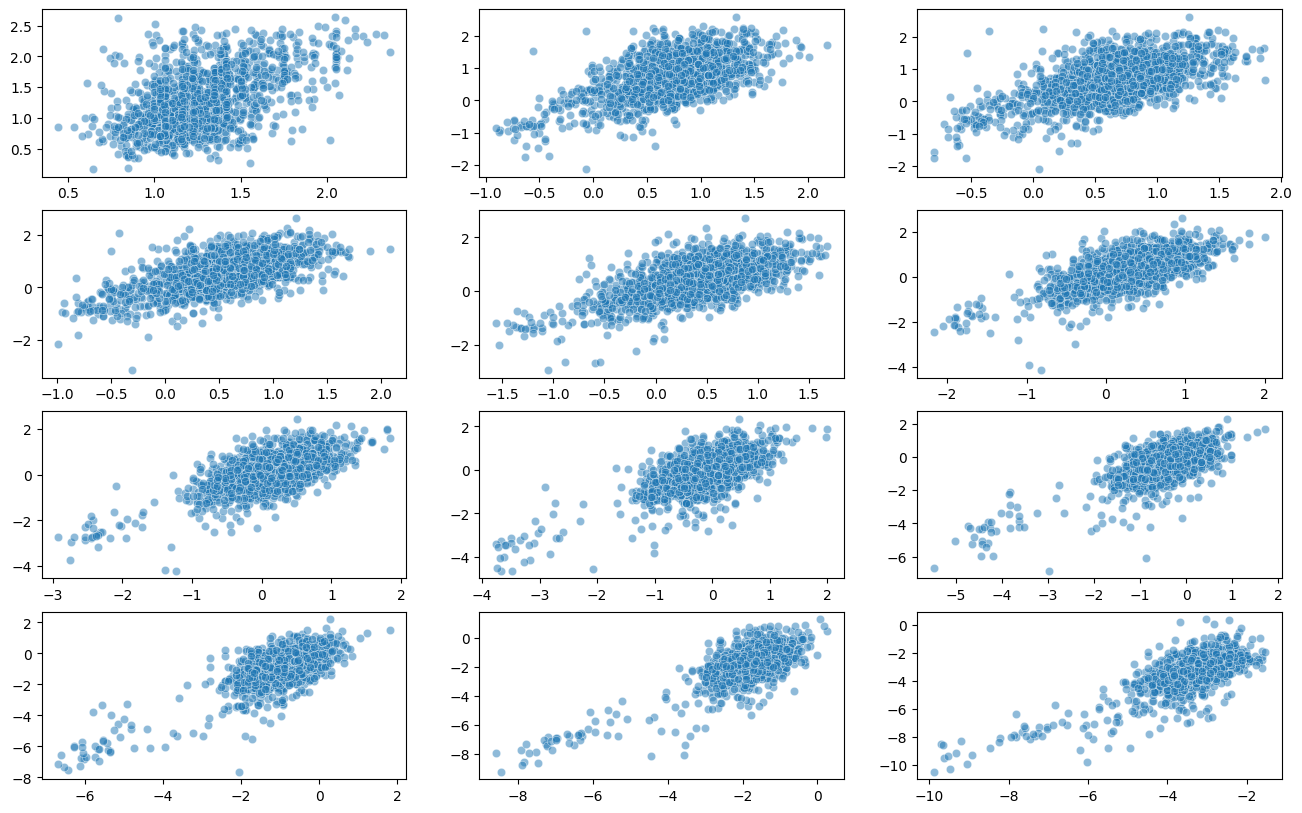

In [11]:
scatter(x = predictions,y = y_test )

In [12]:
eval_batches = []
for i in range(1):
  eval_batches.append(next(owt_iter)["tokens"])

In [13]:
for param in model.parameters():
    param.requires_grad = False

for param in attn_bias:
    param.requires_grad = False

In [14]:
def get_alpha_map(alpha, act):
  return alpha

def get_dir_map(dir, act):
  return dir

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


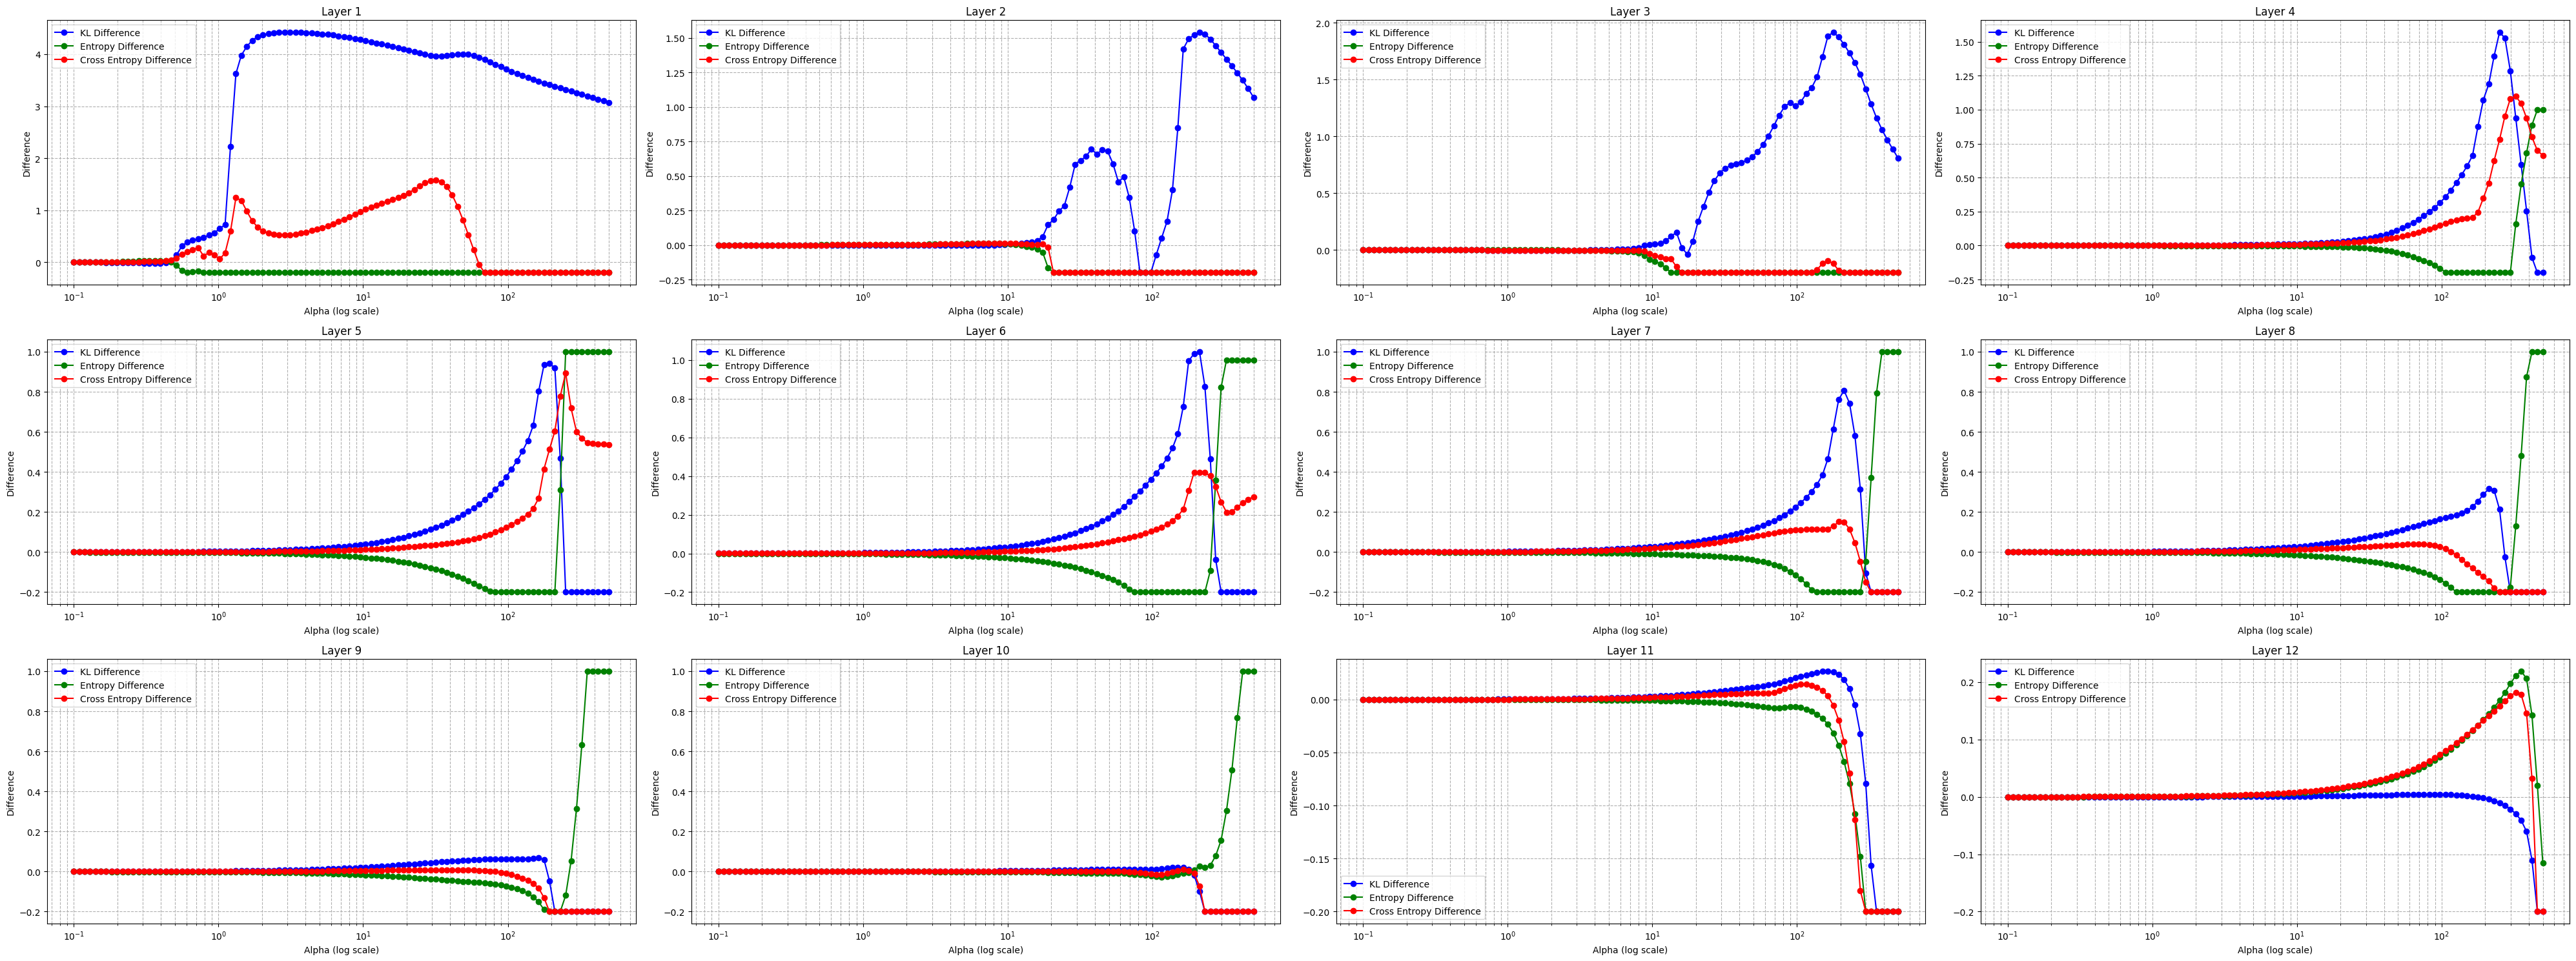

In [15]:
batch = next(owt_iter)["tokens"]
n_layers = 12  # Assuming the model has this attribute and it's 12
kl_loss = torch.nn.KLDivLoss(reduction="none")
n = 100
# Generate alpha values
neg_alphas = np.logspace(np.log10(0.1), np.log10(500), num=n)  # From -1 to -0.0001
alphas = neg_alphas  # Include 0 in the range

# Initialize a storage for KL differences for each layer across alphas
alpha_vs_kl_diff_per_layer = np.zeros((n_layers, len(alphas)))
alpha_vs_entorpy_diff_per_layer = np.zeros((n_layers, len(alphas)))
alpha_vs_crossentorpy_diff_per_layer = np.zeros((n_layers, len(alphas)))
# dirs2 = torch.randn_like(torch.stack(dirs))
for alpha_idx, alpha in tqdm(enumerate(alphas),total=n):
  pure_loss = 0
  patched_loss = 0
  pure_entropy = 0
  patched_entropy = 0

  for btach in eval_batches:

    with torch.no_grad():

        alpha_maps = [partial(get_alpha_map, alpha) for _ in range(n_layers)]
        dir_maps = [partial(get_dir_map, dirs[i]) for i in range(n_layers)]

        output, logits, activation_storage, dir_storage = run_modal_lens_with_dir(model,batch,attn_bias,alpha_maps,dir_maps,batch_size, n_layers)
        pure_loss += kl_loss(logits.softmax(dim=-1).log(), output[:batch_size]).sum(-1)
        # pure_loss += F.cross_entropy(logits.reshape(-1,50257), output[:batch_size].repeat(12,1,1).reshape(-1,50257),reduction = "none").reshape(12, -1)
        patched_loss += kl_loss(logits.softmax(dim=-1).log(), output[batch_size:].unflatten(0, (n_layers, batch_size))).sum(-1)
        # patched_loss += F.cross_entropy(logits.reshape(-1,50257), output[batch_size:],reduction = "none").reshape(12, -1)
        diff = pure_loss.mean(-1)/len(eval_batches) - patched_loss.mean(-1)/len(eval_batches)  # This will be a tensor of shape [n_layers]
        entropy_diff = Categorical(output[:batch_size]).entropy().mean() - Categorical(output[batch_size:].unflatten(0, (n_layers, batch_size))).entropy().mean(-1)

        alpha_vs_entorpy_diff_per_layer[:, alpha_idx] = entropy_diff.detach().cpu().numpy()
        alpha_vs_kl_diff_per_layer[:, alpha_idx] = diff.detach().cpu().numpy()
        alpha_vs_crossentorpy_diff_per_layer[:, alpha_idx] = diff.detach().cpu().numpy() + entropy_diff.detach().cpu().numpy()


# Plotting in 12 subplots
fig, axes = plt.subplots(3, 4, figsize=(40, 15))
axes = axes.flatten()

for layer_no in range(n_layers):

    ax1 = axes[layer_no]

    # Plot KL Difference
    ax1.semilogx(np.abs(alphas), alpha_vs_kl_diff_per_layer[layer_no].clip(min= -.2), marker='o', linestyle='-', color='blue', label='KL Difference')

    # Plot Entropy Difference
    ax1.semilogx(np.abs(alphas), alpha_vs_entorpy_diff_per_layer[layer_no].clip(min= -.2, max = 1), marker='o', linestyle='-', color='green', label='Entropy Difference')

    # Plot Cross Entropy Difference
    ax1.semilogx(np.abs(alphas), alpha_vs_crossentorpy_diff_per_layer[layer_no].clip(min= -.2), marker='o', linestyle='-', color='red', label='Cross Entropy Difference')

    ax1.set_title(f'Layer {layer_no + 1}')
    ax1.set_xlabel('Alpha (log scale)')
    ax1.set_ylabel('Difference')
    ax1.grid(True, which="both", ls="--")
    ax1.legend()

plt.tight_layout()
plt.show()

In [16]:
alphas = alphas[alpha_vs_kl_diff_per_layer.argmax(-1)]
alphas

array([  3.12272209, 211.51280784, 178.07789108, 251.22527907,
       194.07667237, 211.51280784, 211.51280784, 211.51280784,
       163.39797517, 149.92820347, 163.39797517,  82.09940382])

In [17]:
for batch in eval_batches:
  alpha_maps = [partial(get_alpha_map, alpha) for alpha in alphas]
  dir_maps = [partial(get_dir_map, dirs[i]) for i in range(n_layers)]

  output, logits, activation_storage, dir_storage = run_modal_lens_with_dir(model,batch,attn_bias,alpha_maps,dir_maps,batch_size, n_layers)
  pure_kl_loss = kl_loss(logits.softmax(dim=-1).log(), output[:batch_size]).sum(-1)
  patched_kl_loss = kl_loss(logits.softmax(dim=-1).log(), output[batch_size:].unflatten(0, (n_layers, batch_size))).sum(-1)

print(pure_kl_loss.mean(-1))
print()
print(patched_kl_loss.mean(-1))

tensor([3.6566, 2.1038, 1.9308, 1.8011, 1.6427, 1.4797, 1.2593, 0.9603, 0.7574,
        0.5482, 0.2032, 0.0313], device='cuda:0')

tensor([0.3222, 1.2480, 0.8019, 1.0250, 1.0765, 0.9990, 0.8942, 0.8556, 0.6133,
        0.4691, 0.2295, 0.0326], device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret

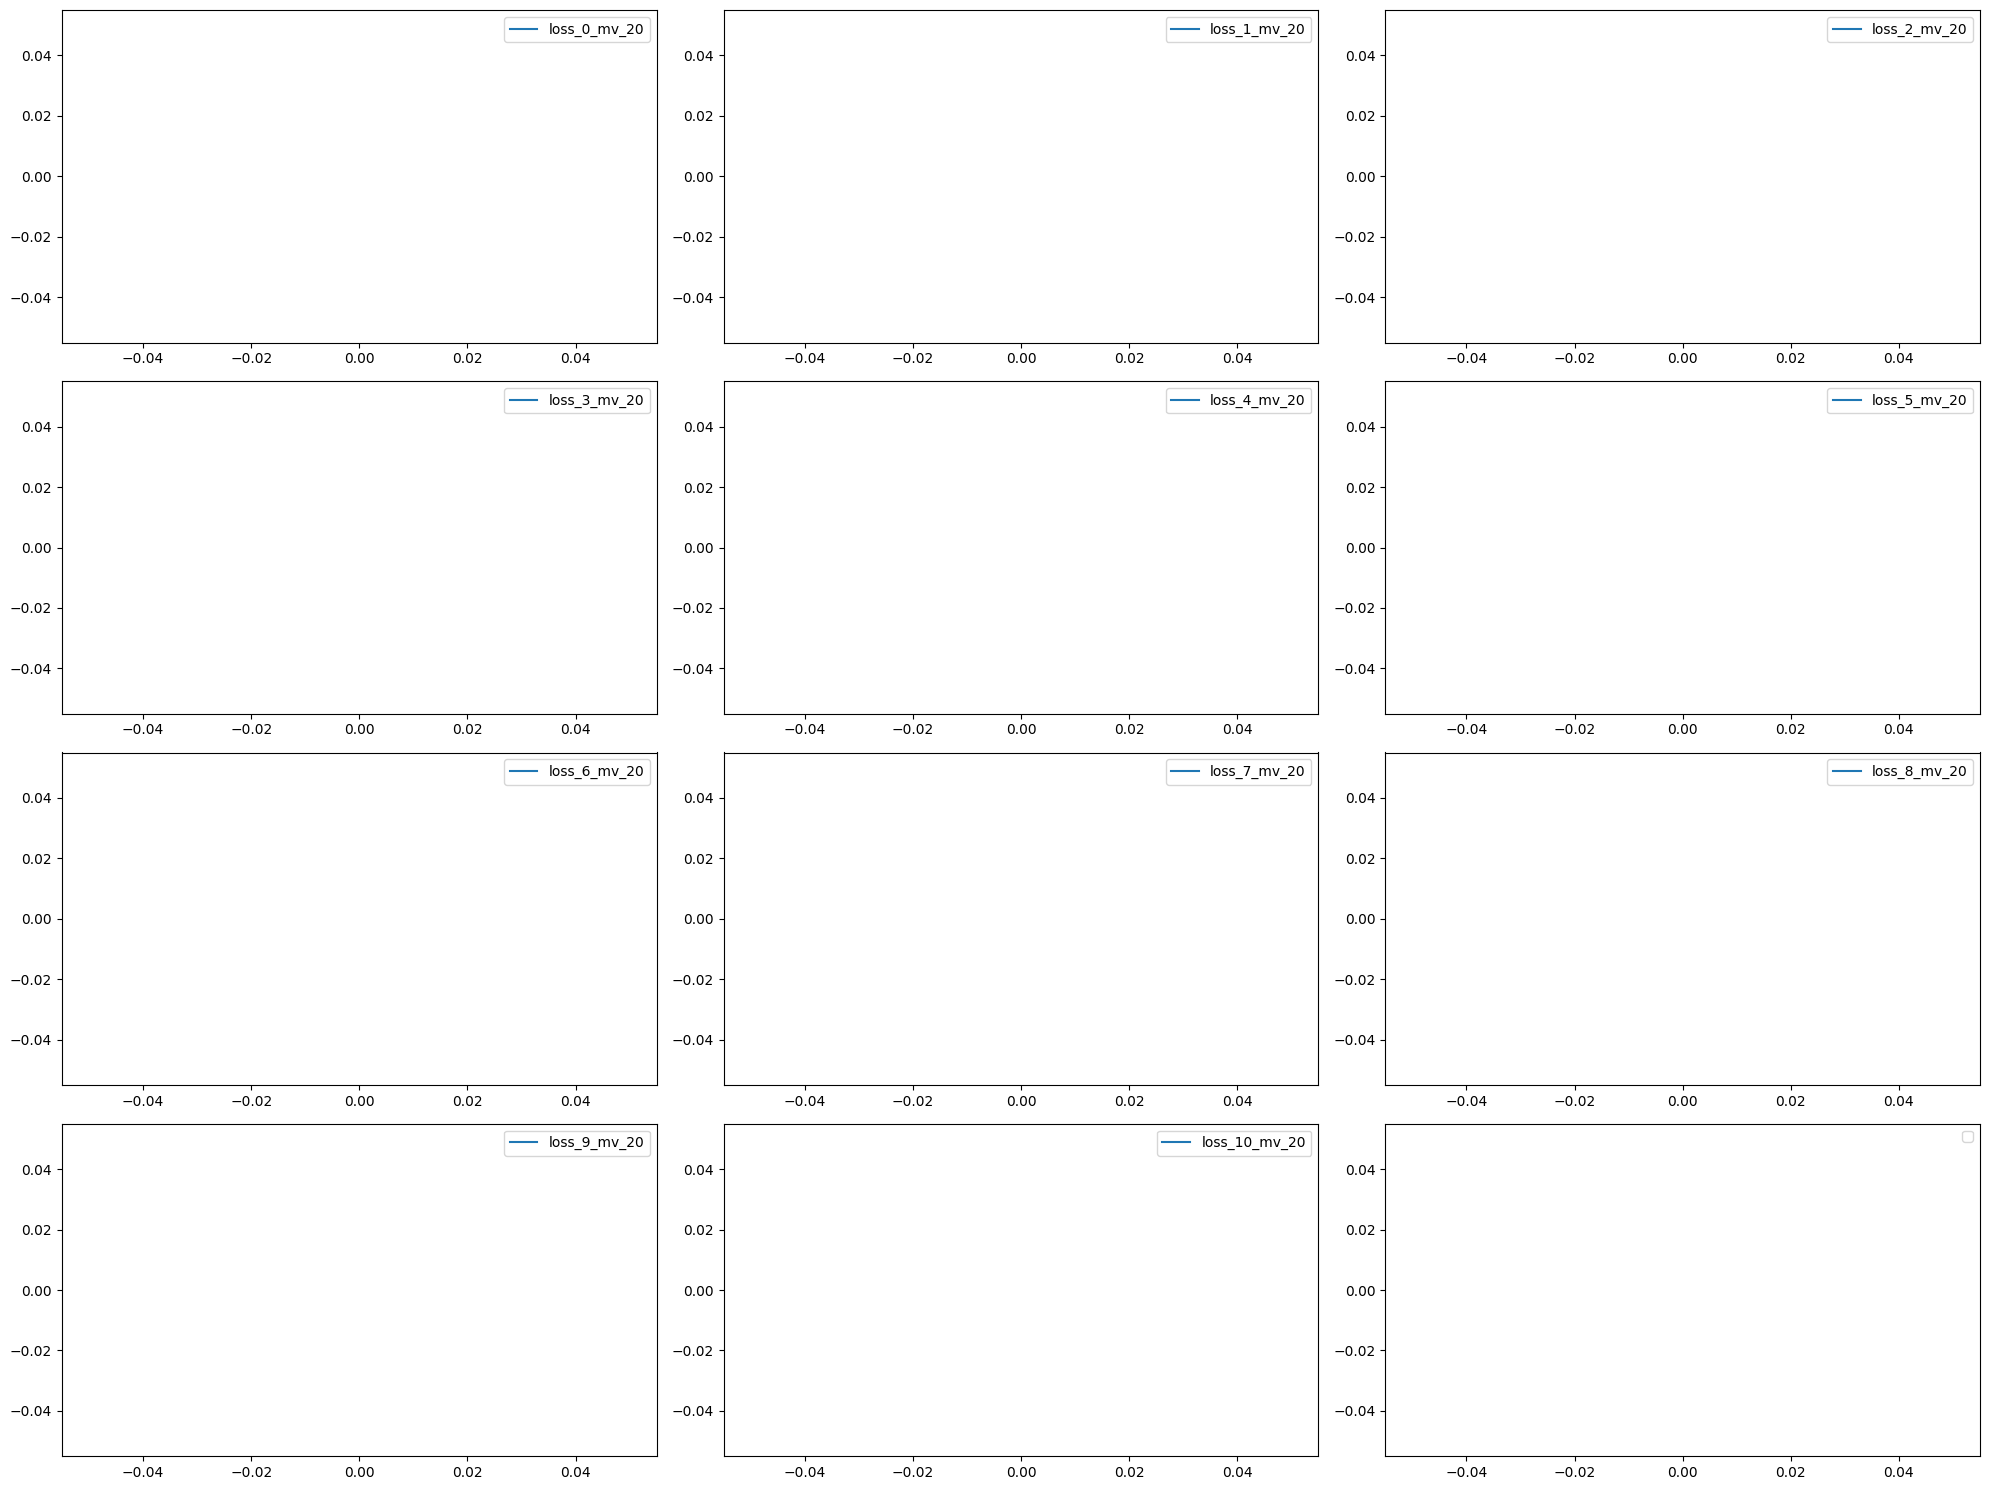

  2%|▏         | 3/200 [00:07<08:01,  2.44s/it]


KeyboardInterrupt: 

In [30]:
all_kl_losses = []
all_pred_losses = []
all_pure_losses = []



for lam in [0.01, 0.1,0.2,0.3,0.4, 0.5,0.6, 0.7, 0.8, 0.9, 0.99]:

  lp = LinePlot([*[f"loss_{k}" for k in range(n_layers)]])
  lr = 1e-3
  dir_tensors = [d.clone().detach().to(device).requires_grad_() for d in dirs]

  dir_maps = [partial(get_dir_map, dir_tensors[i]) for i in range(n_layers)]

  # dir_maps = [torch.nn.Sequential(torch.nn.Linear(d_model,d_model, bias = True, device = device),
  #                               torch.nn.ReLU(),
  #                               torch.nn.Linear(d_model,d_model, bias = True, device = device)) for _ in range(n_layers)]

  # for i in range(n_layers):
  #   for p in dir_maps[i].parameters():
  #     p.data = torch.randn_like(p.data).requires_grad_() *0.01
  #   with torch.no_grad():
  #     list(dir_maps[i].parameters())[-1].data = dir_tensors[i].squeeze()

  # alpha_maps = [partial(get_alpha_map, alpha) for alpha in alphas]

  alpha_maps = [torch.nn.Sequential(torch.nn.Linear(d_model,1, bias = True, device = device),
                                torch.nn.ReLU(),
                                ) for _ in range(n_layers)]
  for i in range(n_layers):
    with torch.no_grad():
      list(alpha_maps[i].parameters())[1].fill_(alphas[i])

  optimizer = torch.optim.AdamW([*dir_tensors] + [param for map in alpha_maps for param in map.parameters()], lr=lr, weight_decay=0)
  # optimizer = torch.optim.AdamW( [param for map in dir_maps for param in map.parameters()] + [param for map in alpha_maps for param in map.parameters()], lr=lr, weight_decay=0)

  kl_losses = []
  pred_losses = []
  pure_losses = []

  for i in tqdm(range(200)):
    batch = next(owt_iter)["tokens"]
    optimizer.zero_grad()
    output, logits, activation_storage, dir_storage = run_modal_lens_with_dir(model,batch,attn_bias,alpha_maps,dir_maps,batch_size, n_layers)

    pure_loss = F.kl_div(logits.softmax(dim=-1).log(), output[:batch_size], reduction="none").sum(-1)
    #kl_loss = F.kl_div(logits.softmax(dim=-1).log(), output[batch_size:].unflatten(0, (n_layers, batch_size)),reduction="none").sum(-1).mean(-1)
    kl_loss = F.kl_div(output[batch_size:].unflatten(0, (n_layers, batch_size)).log(),logits.softmax(dim=-1),reduction="none").sum(-1).mean(-1)


    # pred_loss = (((torch.stack(activation_storage) * torch.stack(dir_storage)).sum(-1).clip(-10,5) - pure_loss.log().clip(10,5))**2).T
    pred_loss = F.mse_loss((torch.stack(activation_storage) * torch.stack(dir_storage).unsqueeze(1)).sum(-1), pure_loss.log(), reduction = "none").T

    loss = (1-lam) * kl_loss+ lam* pred_loss.mean(0)

    loss.mean().backward()

    optimizer.step()

    kl_losses.append(kl_loss.detach().cpu())
    pred_losses.append(pred_loss.detach().cpu())
    pure_losses.append(pure_loss.detach().cpu())

    kl_losses = kl_losses[-50:]
    pred_losses = pred_losses[-50:]
    pure_losses = pure_losses[-50:]


    lp.add_entry({ **{f"loss_{k}": loss[k].item() for k in range(n_layers)}})
    if i % 50 == 0:
          lp.plot(subplots=3, save=f"{folder}/something.png", twinx=False, mv=20, only_mv = True)

  all_kl_losses.append(kl_losses)
  all_pred_losses.append(pred_losses)
  all_pure_losses.append(pure_losses)





In [22]:
torch.stack(dir_storage).shape

torch.Size([12, 768])

In [23]:
torch.stack(activation_storage).shape

torch.Size([12, 16, 768])

In [20]:
(torch.stack(activation_storage) * torch.stack(dir_storage)).shape

RuntimeError: The size of tensor a (16) must match the size of tensor b (12) at non-singleton dimension 1

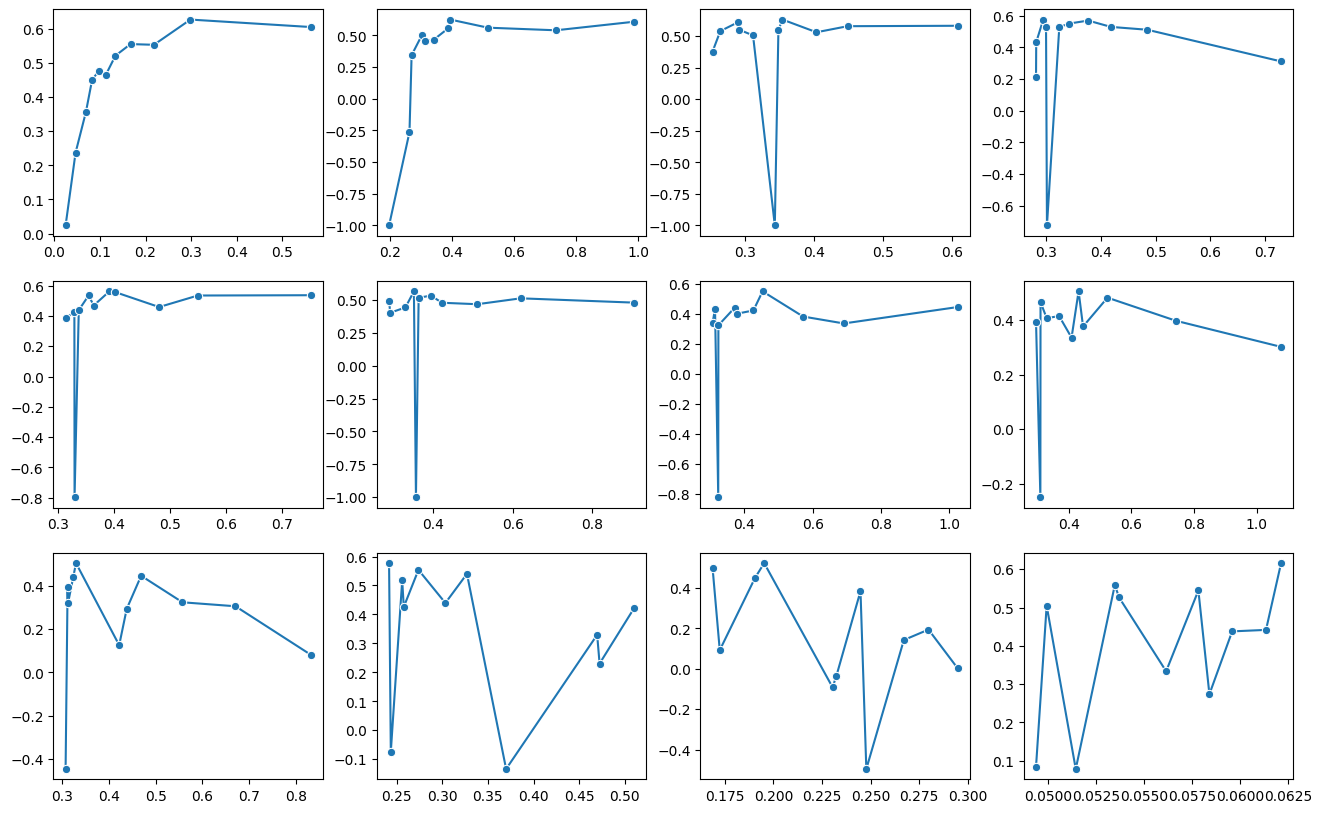

In [ ]:
corrs = []
for i in range(len(all_pure_losses)):
  corrs.append(1 - [torch.cat(x,0) for x in all_pred_losses][i].mean(0) / [torch.cat(x,1) for x in all_pure_losses][i].log().var(1))

fig,axs = plt.subplots(3,4, figsize = [16,10])
axs = axs.flatten()
for i in range(n_layers):
  x = torch.stack([torch.stack(x).mean(0) for x in all_kl_losses])[:,i].numpy()
  y = torch.stack(corrs)[:,i].clip(-1).numpy()
  sns.lineplot(ax = axs[i],x = x,y=y, marker = 'o')

 25%|██▍       | 149/600 [00:27<01:22,  5.44it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtyp

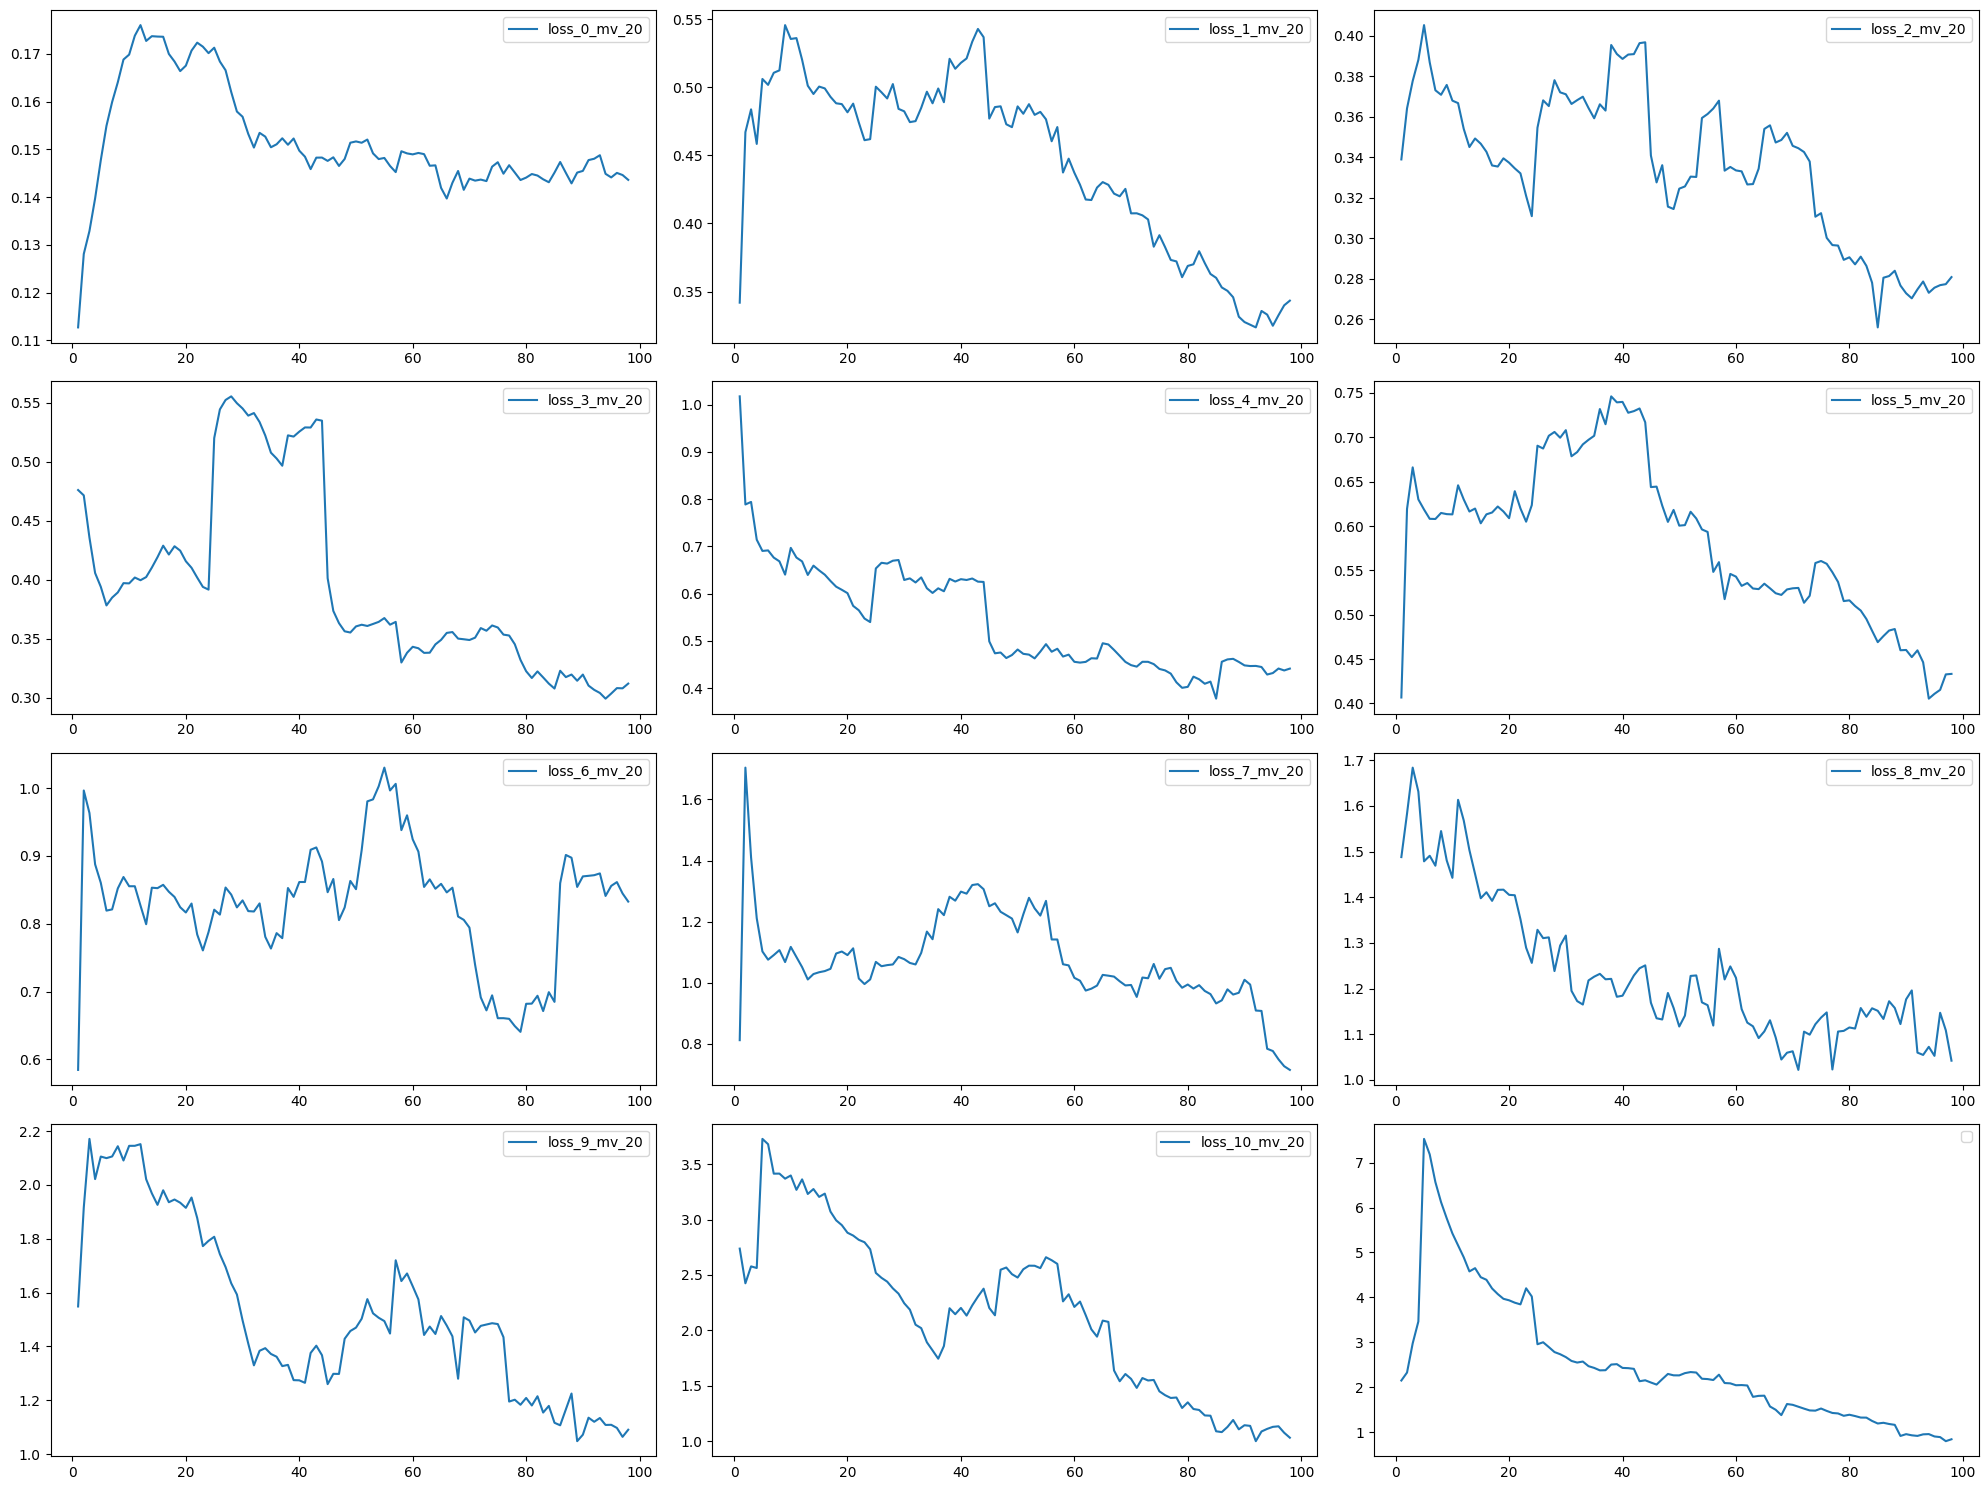

 50%|████▉     | 299/600 [00:58<00:55,  5.43it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtyp

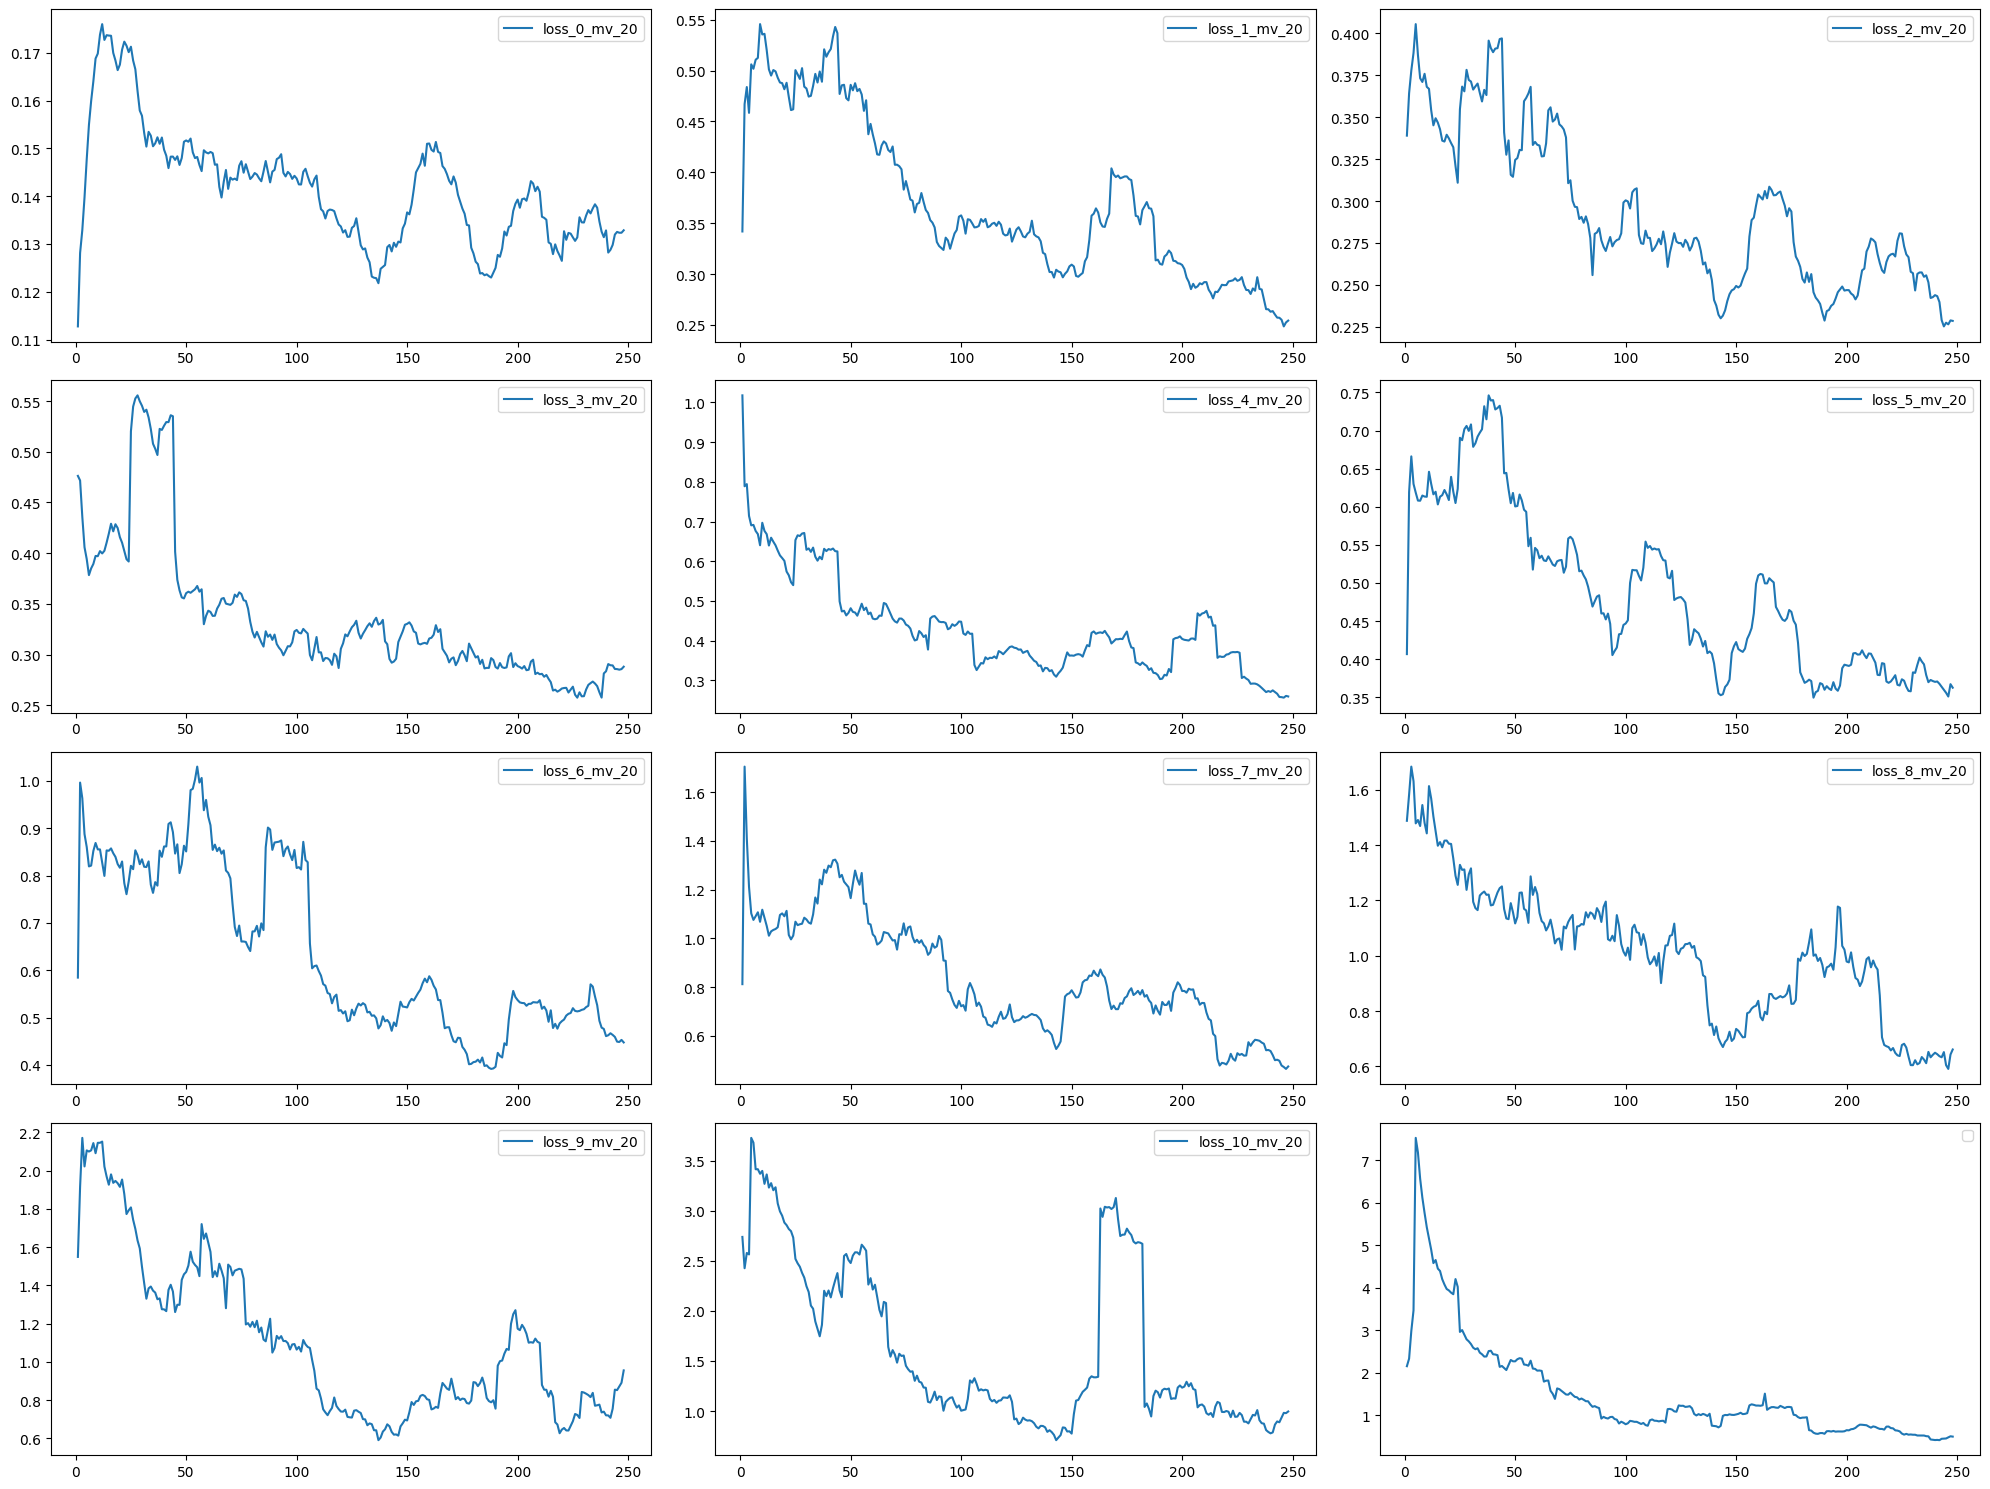

 75%|███████▍  | 449/600 [01:30<00:28,  5.31it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtyp

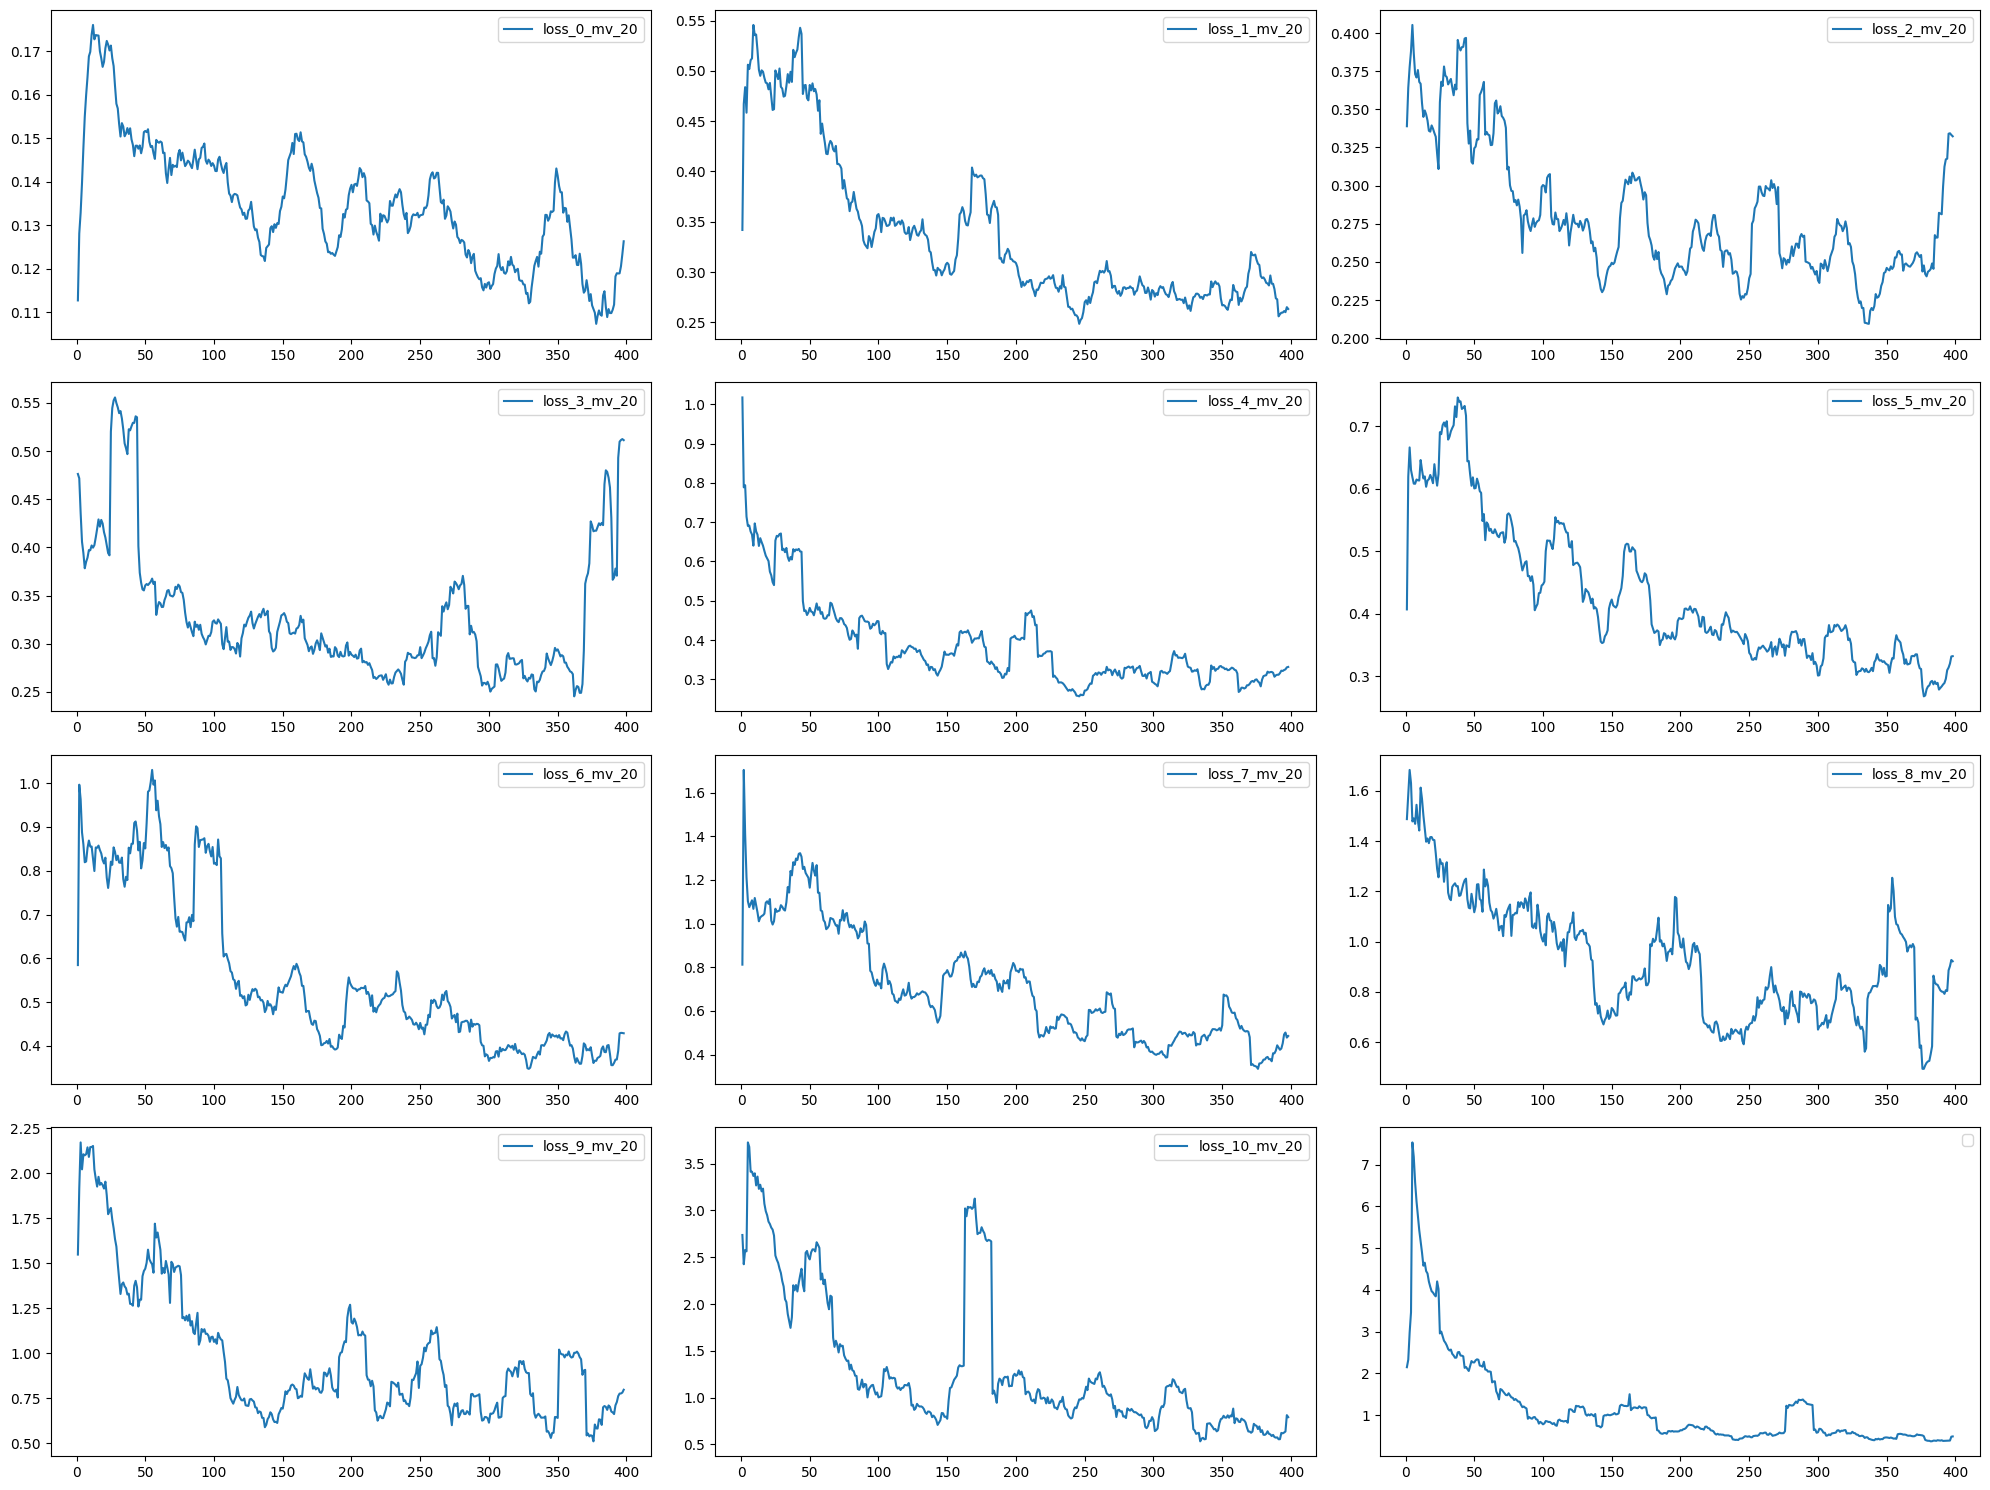

100%|█████████▉| 599/600 [02:01<00:00,  5.27it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtyp

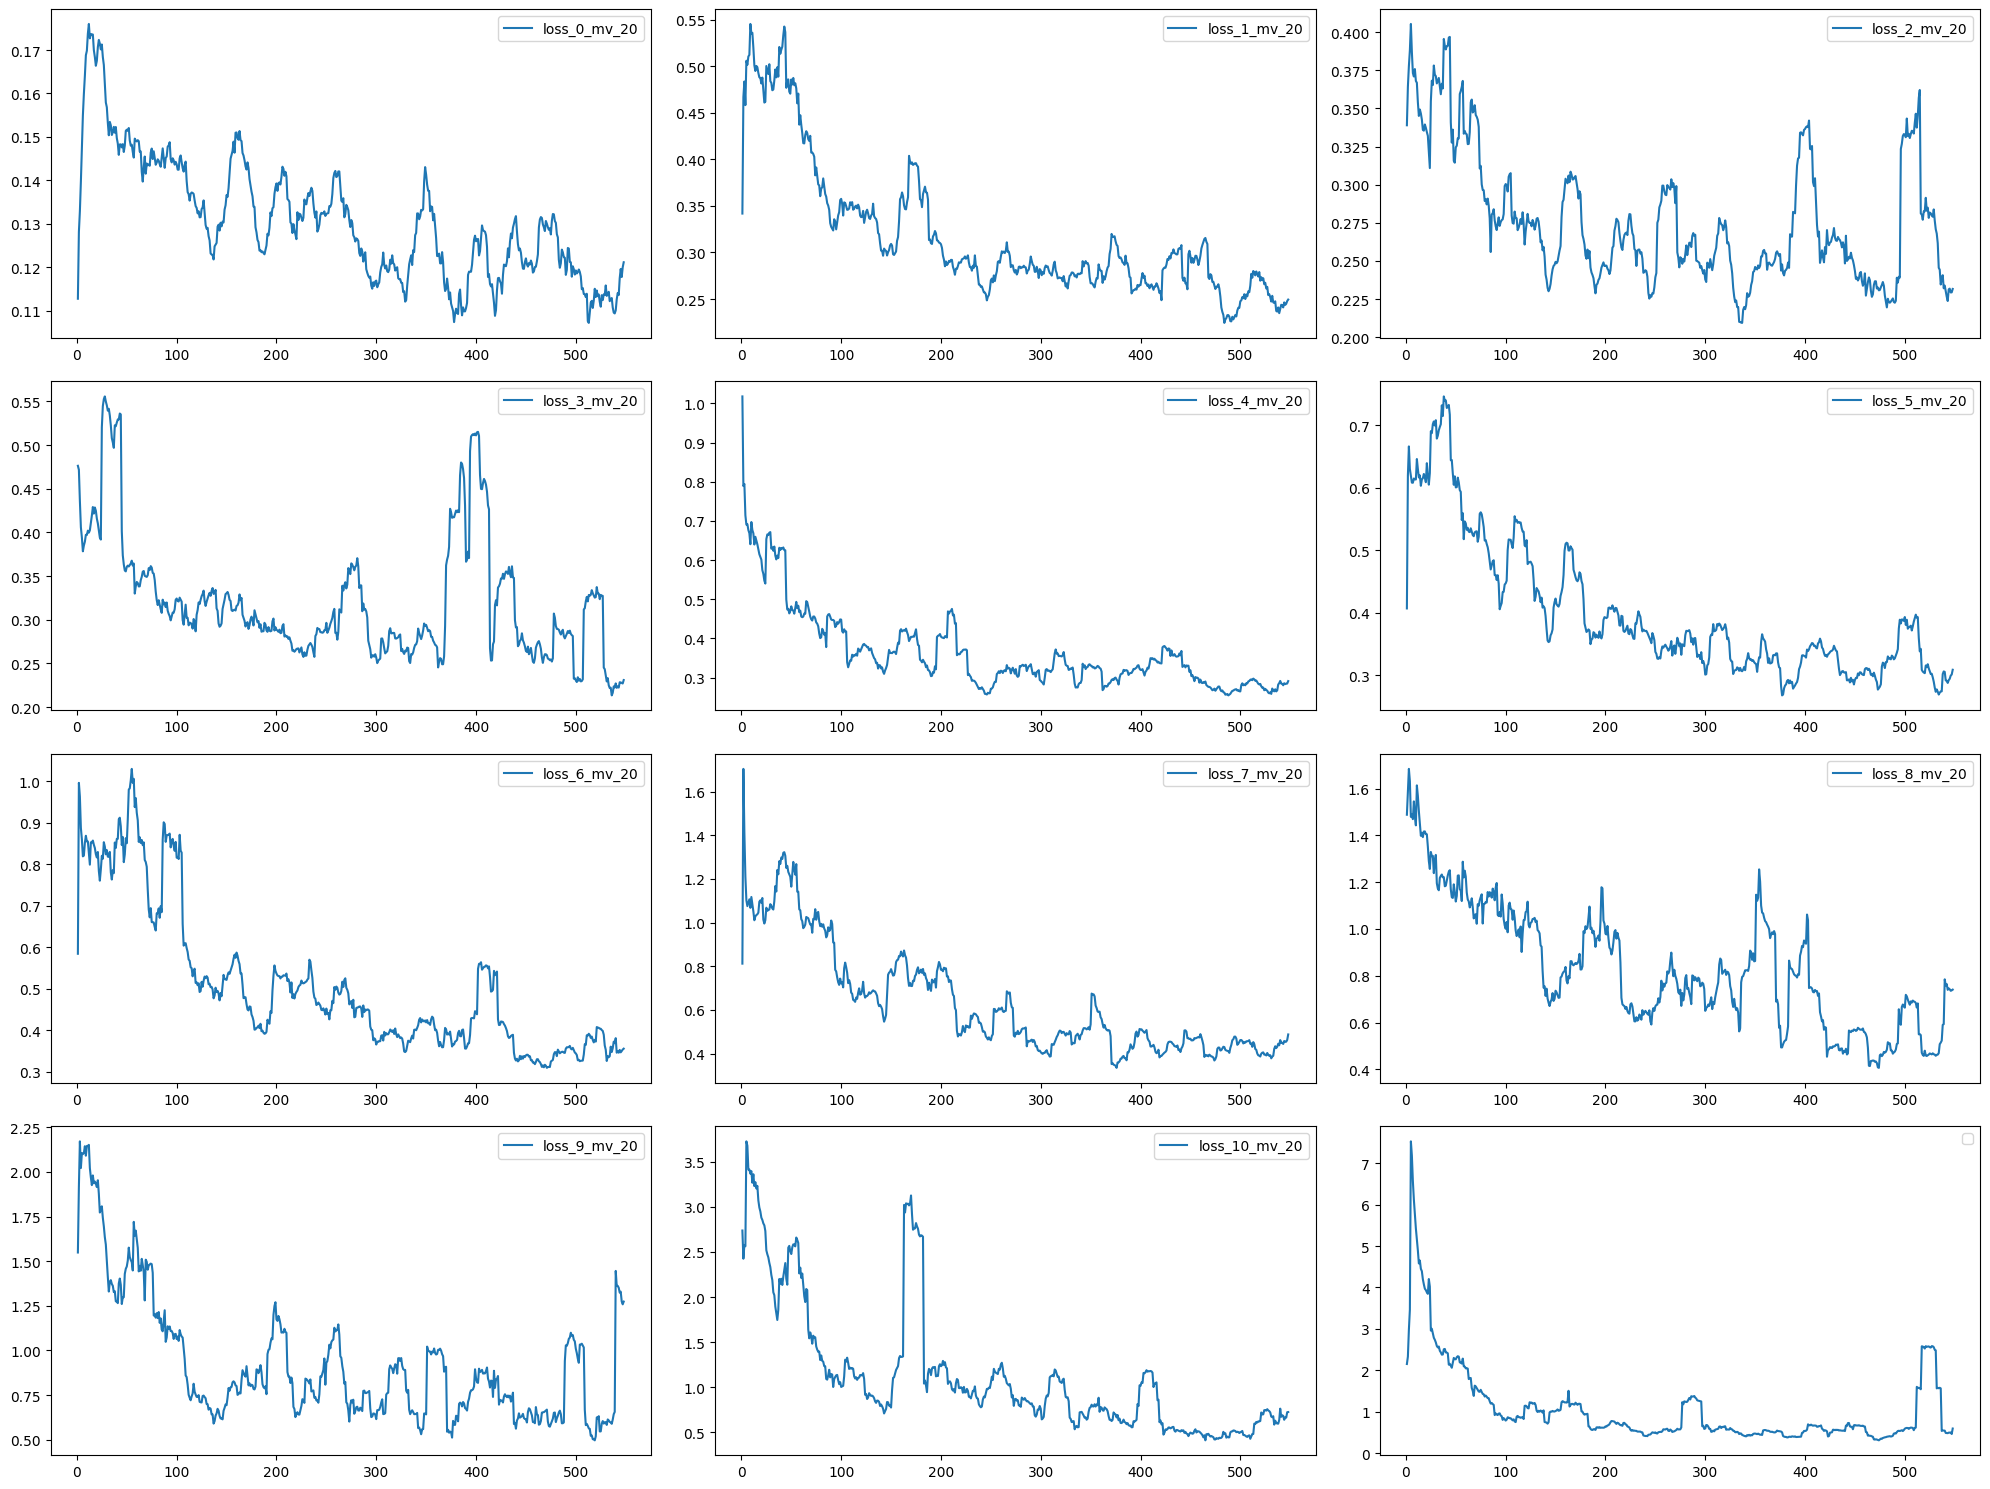

100%|██████████| 600/600 [02:05<00:00,  4.78it/s]


In [ ]:
lam = 0.7

lp = LinePlot([*[f"loss_{k}" for k in range(n_layers)]])
lr = 1e-3
dir_tensors = [d.clone().detach().to(device).requires_grad_() for d in dirs]

# dir_maps = [partial(get_dir_map, dir_tensors[i]) for i in range(n_layers)]

dir_maps = [torch.nn.Sequential(torch.nn.Linear(d_model,d_model, bias = True, device = device),
                              torch.nn.ReLU(),
                              torch.nn.Linear(d_model,d_model, bias = True, device = device)) for _ in range(n_layers)]

for i in range(n_layers):
  for p in dir_maps[i].parameters():
    p.data = torch.randn_like(p.data).requires_grad_() *0.01
  with torch.no_grad():
    list(dir_maps[i].parameters())[-1].data = dir_tensors[i].squeeze()

# alpha_maps = [partial(get_alpha_map, alpha) for alpha in alphas]
alpha_maps = [torch.nn.Sequential(torch.nn.Linear(d_model,1, bias = True, device = device),
                              torch.nn.ReLU(),
                              ) for _ in range(n_layers)]
for i in range(n_layers):
  with torch.no_grad():
    list(alpha_maps[i].parameters())[1].fill_(alphas[i])

# optimizer = torch.optim.AdamW([*dir_tensors] + [param for map in alpha_maps for param in map.parameters()], lr=lr, weight_decay=0)
optimizer = torch.optim.AdamW( [param for map in dir_maps for param in map.parameters()] + [param for map in alpha_maps for param in map.parameters()], lr=lr, weight_decay=0)

kl_losses = []
pred_losses = []
pure_losses = []

for i in tqdm(range(600)):
  batch = next(owt_iter)["tokens"]
  optimizer.zero_grad()
  output, logits, activation_storage, dir_storage = run_modal_lens_with_dir(model,batch,attn_bias,alpha_maps,dir_maps,batch_size, n_layers)

  pure_loss = F.kl_div(logits.softmax(dim=-1).log(), output[:batch_size], reduction="none").sum(-1)
  #kl_loss = F.kl_div(logits.softmax(dim=-1).log(), output[batch_size:].unflatten(0, (n_layers, batch_size)),reduction="none").sum(-1).mean(-1)
  kl_loss = F.kl_div(output[batch_size:].unflatten(0, (n_layers, batch_size)).log(),logits.softmax(dim=-1),reduction="none").sum(-1).mean(-1)


  # pred_loss = (((torch.stack(activation_storage) * torch.stack(dir_storage)).sum(-1).clip(-10,5) - pure_loss.log().clip(10,5))**2).T
  pred_loss = F.huber_loss((torch.stack(activation_storage) * torch.stack(dir_storage)).sum(-1), pure_loss.log(), reduction = "none").T

  loss = (1-lam) * kl_loss+ lam* pred_loss.mean(0)

  loss.mean().backward()

  optimizer.step()

  kl_losses.append(kl_loss.detach().cpu())
  pred_losses.append(pred_loss.detach().cpu())
  pure_losses.append(pure_loss.detach().cpu())

  kl_losses = kl_losses[-100:]
  pred_losses = pred_losses[-100:]
  pure_losses = pure_losses[-100:]

  if i> 50:
    lp.add_entry({ **{f"loss_{k}": loss[k].item() for k in range(n_layers)}})
  if i % 150 == 149:
        lp.plot(subplots=3, save=f"{folder}/something.png", twinx=False, mv=20, only_mv = True)




In [ ]:
kl_loss = torch.nn.KLDivLoss(reduction = "none")
for batch in eval_batches:

  output, logits, activation_storage, dir_storage = run_modal_lens_with_dir(model,batch,attn_bias,alpha_maps,dir_maps,batch_size, n_layers)
  pred_loss = (((torch.stack(activation_storage).permute(1,0,2) * torch.stack(dir_tensors)).sum(-1).permute(1,0) - pure_loss.log())**2).T
  pure_kl_loss = kl_loss( output[:batch_size].log(),logits.softmax(dim=-1)).sum(-1)
  patched_kl_loss = kl_loss(output[batch_size:].unflatten(0, (n_layers, batch_size)).log(),logits.softmax(dim=-1)).sum(-1)


print(1- (torch.cat(pred_losses).cpu()/ torch.cat(pure_losses,1).log().var(-1).unsqueeze(0)).mean(0))
print()
print(pure_kl_loss.mean(-1))
print()
print(patched_kl_loss.mean(-1))
print()
print((pure_kl_loss.mean(-1) - patched_kl_loss.mean(-1))/pure_kl_loss.mean(-1))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
alpha_maps[0]

Sequential(
  (0): Linear(in_features=768, out_features=1, bias=True)
  (1): ReLU()
)

In [ ]:
kl_loss = torch.nn.KLDivLoss(reduction = "none")


pure_losses = []
activation_storages = []
patched_losses = []
pred_losses = []
dirs = []

for _ in range(100):
  with torch.no_grad():
    batch = next(owt_iter)["tokens"]
    output, logits, activation_storage, dir_storage = run_modal_lens_with_dir(model,batch,attn_bias,alpha_maps,dir_maps,batch_size, n_layers)
    pure_kl_loss = kl_loss(logits.softmax(dim=-1).log(), output[:batch_size]).sum(-1)
    patched_kl_loss = kl_loss(logits.softmax(dim=-1).log(), output[batch_size:].unflatten(0, (n_layers, batch_size))).sum(-1)

    pred_loss = (((torch.stack(activation_storage) * torch.stack(dir_storage)).sum(-1) - pure_loss.log())**2).T

    pure_losses.append(pure_kl_loss)
    patched_losses.append(patched_kl_loss)
    activation_storages.append(torch.stack(activation_storage))
    dirs.append(torch.stack(dir_storage))
    pred_losses.append(pred_loss)




# print(1- (torch.cat(pred_losses).cpu()/ torch.cat(pure_losses,1).log().var(-1).unsqueeze(0)).mean(0))
# print()
print(torch.cat(pure_losses,1).mean(-1))
print()
print(torch.cat(patched_losses,1).mean(-1))
print()
print((pure_kl_loss.mean(-1) - patched_kl_loss.mean(-1))/pure_kl_loss.mean(-1))

tensor([4.0057, 2.5347, 2.3462, 2.1103, 1.8839, 1.7119, 1.4570, 1.1443, 0.8338,
        0.5110, 0.2379, 0.0535], device='cuda:0')

tensor([0.1542, 0.4143, 0.4033, 0.4266, 0.4553, 0.4767, 0.4940, 0.5128, 0.5120,
        0.4742, 0.3659, 0.0595], device='cuda:0')

tensor([ 9.6079e-01,  8.2587e-01,  8.6224e-01,  8.5606e-01,  8.1009e-01,
         7.4839e-01,  6.6283e-01,  6.0776e-01,  6.4216e-02, -7.3986e-01,
        -1.4275e+00, -1.0532e-05], device='cuda:0')


In [ ]:
print(1- (torch.cat(pred_losses)/ torch.cat(pure_losses,1).log().var(-1).unsqueeze(0)).mean(0))

tensor([-1.3768e-01, -1.1240e+00, -1.1595e+01, -1.3743e+01, -9.9996e+01,
        -1.5177e+01, -1.3945e+01, -1.5494e+02, -3.5359e+02, -7.7793e+02,
        -3.7536e+03, -5.0281e+03], device='cuda:0')


In [ ]:
torch.cat(pure_losses,1).shape

torch.Size([12, 1600])

In [ ]:
dirs,r2s,preds,y_tests = fit_beta_model(((torch.cat(dirs,1) * torch.cat(dirs,1)).sum(-1) ** 0.5).T.unsqueeze(2).detach().cpu().numpy(), torch.cat(pure_losses,1).detach().cpu().numpy().T)
r2s

[(0.001, 0.004),
 (0.0, -0.011),
 (0.001, -0.015),
 (0.005, -0.01),
 (0.005, 0.005),
 (0.006, -0.003),
 (0.011, -0.005),
 (0.017, -0.001),
 (0.023, 0.032),
 (0.02, 0.005),
 (0.006, 0.003),
 (0.002, 0.007)]

In [ ]:
a = []
for i,act in enumerate(torch.cat(activation_storages,1)):
  a.append(alpha_maps[i](act))


dirs,r2s,preds,y_tests = fit_beta_model(torch.stack(a).permute(1,0,2).detach().cpu().numpy(), torch.cat(pure_losses,1).detach().cpu().numpy().T)
r2s

[(0.002, 0.006),
 (0.0, -0.029),
 (0.018, -0.027),
 (0.015, -0.015),
 (0.009, -0.023),
 (0.008, -0.01),
 (0.029, 0.036),
 (0.0, -0.007),
 (0.002, -0.005),
 (0.0, -0.013),
 (0.01, -0.006),
 (0.016, 0.003)]

In [ ]:
torch.stack(a).permute(1,0,2).detach().cpu().numpy().shape

(128, 12, 1)

In [ ]:
r2s

[(0.001, -0.685),
 (0.014, -0.601),
 (0.063, -0.253),
 (0.0, -0.201),
 (0.218, -0.371),
 (0.457, -0.425),
 (0.424, 0.493),
 (0.453, -108.952),
 (0.05, 0.312),
 (0.035, -13.438),
 (0.13, -1.413),
 (0.0, -4.117)]

In [ ]:
activation_storage[0].shape

torch.Size([1, 768])

In [ ]:
(-1* output[:batch_size]* output[:batch_size].log()).sum(-1).mean(-1)

tensor(4.4391, device='cuda:0', grad_fn=<MeanBackward1>)

In [ ]:
(output[batch_size:].reshape(12,batch_size,-1) * output[batch_size:].reshape(12,batch_size,-1).log() * -1).sum(-1).mean(-1)

tensor([7.6373, 5.7965, 6.5159, 6.6587, 6.6196, 6.3901, 6.1868, 5.8493, 5.4898,
        5.0205, 4.8067, 4.3184], device='cuda:0', grad_fn=<MeanBackward1>)

In [ ]:
sentence = "I need a lot of"

x = tokenizer(sentence, return_tensors="pt")["input_ids"]
with torch.no_grad():
    output, logits, activation_storage,dirs = run_modal_lens_with_dir(model,x,attn_bias,alpha_maps,dir_maps,1,n_layers)


show_token_preds(logits.softmax(-1), output[0], tokenizer, sentence)

Sentence: I need a lot of


In [ ]:
show_token_preds(output[1:], output[0], tokenizer, sentence)

Sentence: I need a lot of
